## Homework 1 - Finding similar items

## Shingling / Shingles

> **Lab description**: *A class Shingling that constructs k–shingles of a given length k (e.g., 10) from a given document, computes a hash value for each unique shingle and represents the document in the form of an ordered set of its hashed k-shingles.*

The first part of this homework is to implement the shingling algorithm. The shingling algorithm takes a document and breaks it into a set of k-shingles. For example, if we have the document "Hello World" and we use a k-shingle size of 3, we would get the following shingles:
```bash
    {Hel, ell, llo, lo ,o W, Wo, or, rl, ld}
```
The shingling algorithm is implemented in the `shingling` class. The function takes a document and a k-shingle size and returns a set of shingles. The function is implemented in the cell below.

Notable details of our implementation:
- We use Python's native hash function to compute the hash value of each shingle and modulo max value of an unsigned int $(2^32 - 1)$.
- We use a set to store the shingles, which is a data structure that only stores unique elements. This is useful because we don't want to store duplicate shingles. It also allows for convinient set operations later on.


In [19]:
class Shingling:
  def __init__(self, text, k):
    self.shingles = self.constructShingles(text, k)
    self.hashed_shingles = self.constructHashedShingles(text, k)

  def constructShingles(self, s, k=5):
    """
    Split a (lower case) string into k equal sizes.
    """
    return set([s[i:(i+k)].lower() for i in range(0, len(s)-k+1)])

  def constructHashedShingles(self, text, k=5, hashBoundary=((2**32)-1)):
    """
    Using above function to construct shingles, and then hash them.
    """
    shingles = self.constructShingles(text, k)
    hashed_shingles = [hash(shingle) % hashBoundary for shingle in shingles]
    return set(hashed_shingles)


By using the examples provided in the lecture (`factorial` vs `editorial`), we demonstrate our `Shingling` class in the next cell.

In [20]:
# examples from lecture
editorial = "editorial"
factorial = "factorial"

shingle_length = 5

shingling_editorial = Shingling(editorial, shingle_length)
shingling_factorial = Shingling(factorial, shingle_length)

shinglings = [shingling_editorial, shingling_factorial]

print("Shingles for editorial: ", shinglings[0].shingles)
print("Shingles for factorial: ", shinglings[1].shingles)
print("Matching: ", shinglings[0].shingles & shinglings[1].shingles)

print("\nHashed shingles for editorial: ", shinglings[0].hashed_shingles)
print("Hashed shingles for factorial: ", shinglings[1].hashed_shingles)
print("Matching: ", shinglings[0].hashed_shingles & shinglings[1].hashed_shingles)

Shingles for editorial:  {'orial', 'ditor', 'edito', 'itori', 'toria'}
Shingles for factorial:  {'facto', 'orial', 'actor', 'ctori', 'toria'}
Matching:  {'toria', 'orial'}

Hashed shingles for editorial:  {2045878978, 3516216712, 786809002, 1523537460, 112851898}
Hashed shingles for factorial:  {3131635656, 786809002, 856325643, 400798385, 1523537460}
Matching:  {786809002, 1523537460}


## Compare Sets

> **Lab description:** *A class CompareSets computes the Jaccard similarity of two sets of integers – two sets of hashed shingles.*

The next part of this homework is to implement the Jaccard similarity. Since we implements Shingles with Python sets, we can use Python's built-in set operations. To this end it is sufficent to use `&` and `|`. The `CompareSets` class is implemented in the cell below.

In [21]:
import numpy as np

class CompareSets:

  def similarity(sel, A, B):
    """
    Jaccardi similarity between two sets of hashed shingles.
    """
    return len(A & B) / len(A | B)

  def distance(self, A, B):
      """
      Jaccardi distance.
      """
      return 1-self.similarity(A, B)

Now we demonstrate the class by comparing the shingles of `factorial` and `editorial`.

In [22]:
# create a new 'compare' object
comparer = CompareSets()
similarity = comparer.similarity(A=shingling_editorial.hashed_shingles, 
                                 B=shingling_factorial.hashed_shingles)

print('Jaccardi Similarity:', similarity)

Jaccardi Similarity: 0.25


## MinHashing

> **Lab description**: *A class MinHashing that builds a minHash signature (in the form of a vector or a set) of a given length n from a given set of integers (a set of hashed shingles).*

The next part of this homework is to implement the MinHashing algorithm. We make a MinHashing class that takes a set of shingles and a returns a signature. The class is implemented in the cell below.
Notable details of our implementation:
- We have a method to construct the *characteristic matrix* and two different implementations of finding the signature matrix.
    * `createSigMatPer` requries the characteristic matrix to be constructed and then finds the signature matrix by using permutations. It is slow and less space efficent.
    * `createSigMatHash` finds the signature matrix *without* constructing the characteristic matrix. It is faster and more space efficent.
- We use a hash function on the form of $ax+b \mod N$, where $a$ and $b$ are random numbers ($a, b < 2^{32}-1$) and $N$ is the prime number closest to, and greater than, $2^{32}-1$ (found by table of known prime numbers).

In [23]:
import numpy as np

class MinHashing:

  def constructCharMat(self, shingleList):
    union = set().union(*shingleList)
    return np.array([[int(e in s) for s in shingleList] for e in union])

  def createSigMatPer(self, shingleList, K=100):
    charMat = self.constructCharMat(shingleList)
    sigMat = []
    
    for i in range(K):
      perCharMat = np.take(charMat, np.random.RandomState(seed=i).permutation(charMat.shape[0]),axis=0)
      sigMatRow = [np.where(col == 1)[0][0] for col in perCharMat.T]
      sigMat.append(sigMatRow)

    return np.array(sigMat)

  def createSigMatHash(self, shingleList, K=100):
    # assign max value to use as boundary when finding a and b
    max_int = 2**32-1
    # a prime number larger than max_int, but still not too large
    prime = 4294967311

    # generate K random a and b values, bounded by maxID
    a = self.getHashCoefficients(upper_bound=max_int, K=K, seed=1)
    b = self.getHashCoefficients(upper_bound=max_int, K=K, seed=2)

    # create the signature matrix of size K x len(setList) by hashing each set and finding the minum value
    # TODO parallellize this?
    sigMat = np.array([[np.min([(a[i] * e + b[i]) % prime for e in s]) for s in shingleList] for i in range(K)])
    return sigMat
     
  def getHashCoefficients(self, upper_bound, K=100, seed=1):
    return np.random.RandomState(seed=seed).randint(low=0, high=upper_bound, size=K, dtype=np.uint32)




Below we demonstrate our implementation of the signature matrix by comparing the signatures of `factorial` and `editorial`.

In [24]:
import pandas as pd
# store the shingles in a list for convenience
shingles = [shingling_editorial.shingles, shingling_factorial.shingles]

# find their union (also called 'document vector space')
union = set().union(*shingles)

# create a new minhash object
minHash = MinHashing()

# construct the characteristic matrix
charMat = minHash.constructCharMat(shingles)

# Out of courtesy, we mask the output of 'charMat' as a Panda dataframe
pd.DataFrame(charMat, index=list(set().union(*shingles)), columns=['\"Editorial\"', '\"Factorial\"'])


,"""Editorial""","""Factorial"""
facto,0,1
orial,1,1
actor,0,1
ditor,1,0
edito,1,0
itori,1,0
ctori,0,1
toria,1,1


Here we compare the signatures of `factorial` and `editorial` using the `createSigMatHash` method. The rows are enumerated hash functions, and the columns are the documents.

In [25]:
hashed_shingles = [shingling_editorial.hashed_shingles, shingling_factorial.hashed_shingles]
union = union = set().union(*hashed_shingles)

# NOTE: as number of hash functions increases, the similarity converges to the true similarity
number_of_hash_functions = 100
sigMat = minHash.createSigMatHash(hashed_shingles, K=number_of_hash_functions)

# signature matrix is a (number of hash functions) x (number of documents) matrix
df = pd.DataFrame(sigMat, columns=['\"Editorial\"', '\"Factorial\"'])
df.index.name = 'Hash function #'
df

,"""Editorial""","""Factorial"""
Hash function #,,
0,1301443494,625465253
1,200381731,215242056
2,2051311986,983940
3,184034005,184034005
4,923525835,6961639
...,...,...
95,2327052499,2527611667
96,356954214,889943588
97,1531581531,61919623


Since we employed two different methods to find the signature matrix, we can compare the two methods. For `editorial` vs `factorial`, the approach using hash functions has a speed-up of ~4.5x. It makes sense, because the latter approach does not require the construction of the characteristic matrix.

In [26]:
# store the shingles in a list for convenience
shingles = [shingling_editorial.hashed_shingles, shingling_factorial.hashed_shingles]
union = set().union(*shingles)

# setup matrices
minHash = MinHashing()
charMat = minHash.constructCharMat(shingles)
number_of_hash_functions = 100

# ----- Creating Signature Matrix with Permutations -----
print("Creating Signature Matrix with Permutations and K =", number_of_hash_functions)
%timeit minHash.createSigMatPer(shingles, number_of_hash_functions)

# ----- Creating Signature Matrix with Hashing -----
print("\nCreating Signature Matrix with Hashing and K =", number_of_hash_functions)
%timeit minHash.createSigMatHash(shingles, number_of_hash_functions)

Creating Signature Matrix with Permutations and K = 100
17.5 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Creating Signature Matrix with Hashing and K = 100
4.79 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Compare Signatures

> **Lab description**: *A class CompareSignatures estimates the similarity of two integer vectors – minhash signatures – as a fraction of components in which they agree.*

We made a short class to compare the signatures of two columns of a signature matrix. The class is implemented in the cell below.

In [27]:
import numpy as np

class CompareSignatures:
  def similarity(self, document1, document2):
    return (np.sum(document1 == document2)) / len(document1)

We demonstrate the class by comparing the signatures of `factorial` and `editorial`. The documents are too small for any significant difference to be observed between permutations and hash functions.

In [28]:
# set up the comparer and signuture matrices of type 1) permutations, 2) hash functions
signature_comparer = CompareSignatures()
number_of_hash_functions = 100
signature_permutations = minHash.createSigMatPer(shingles, number_of_hash_functions)
signature_hash_functions = minHash.createSigMatHash(shingles, number_of_hash_functions)

print('Signature Matrix Similarity Permutation:', signature_comparer.similarity(signature_permutations[:,0], signature_permutations[:,1]))
print('Signature Matrix Similarity Hash:', signature_comparer.similarity(signature_hash_functions[:,0], signature_hash_functions[:,1]))

Signature Matrix Similarity Permutation: 0.25
Signature Matrix Similarity Hash: 0.26


## Locality-Sensitive Hashing

> **Lab description:** *A class LSH that implements the LSH technique: given a collection of minhash signatures (integer vectors) and a similarity threshold t, the LSH class (using banding and hashing) finds candidate pairs of signatures agreeing on at least a fraction t of their components.*

The next part of this homework is to implement the LSH algorithm. We make a LSH class that takes a signature matrix and a similarity threshold and returns a list of candidate pairs. The class is implemented in the cell below.

#### Breif explanation of the LSH algorithm
 Since the vocabulary is large, and we have to compare each document pairwise, the amount of comparisons required is (N choose 2), where N is the number of documents. This is a lot of comparisons. We want to reduce the number of comparisons by locating candidate pairs that are similar. To this end, we use LSH. We divide the signature matrix into bands, and for each band we hash the rows. If two rows have the same hash value, they are likely to be similar. We then compare the rows pairwise. The class is implemented in the cell below.

According to the course litterature, we assume that two slices of a given column (row = *document*) are candidate pairs if and only if they have identical elements. Thus, we don't have to implement a particular hash functions, but can use Python's. Frozen sets are a hashable data structure in Python that ensure that the hash value is independent of the order of the elements.

In [29]:
import numpy as np

class LSH:

  def estimateBandR(self, sigMat, simThresh=0.8):
    # rangeMax = int(len(sigMat)/math.log(len(sigMat)))
    rangeMax = len(sigMat)
    brSolutions = [[b,r] for b in range(rangeMax) for r in range(rangeMax) if (b * r)==len(sigMat)]

    similarities = [(1/ab[0])**(1/ab[1]) for ab in brSolutions]

    closestFit = min(similarities, key=lambda x:abs(x-simThresh))
    index = similarities.index(closestFit)
    return brSolutions[index][0], brSolutions[index][1]

  def findCandidatePairs(self, sigMat, threshold=0.80, bands=None, k=10**6):

    if bands is None:
      b, r = self.estimateBandR(sigMat, threshold)

    # assume that the number of rows is evenly divisible by the number of bands
    assert len(sigMat) % b == 0

    candidate_pairs = []

    for i in range(sigMat.shape[1]):
      for j in range(sigMat.shape[1]):
        if i == j:
          continue
        
        for n in range(b):
          # use frozen sets since it is hashable
          hashBand1 = hash(frozenset(sigMat[n*r:(n+1)*r,i])) % k
          hashBand2 = hash(frozenset(sigMat[n*r:(n+1)*r,j])) % k

          if hashBand1 == hashBand2:
            # print((i,j))
            if (i,j) not in candidate_pairs and (j,i) not in candidate_pairs:
              candidate_pairs.append((i,j))
              # print((i,j))
            break

    print(sigMat.shape[1], 'documents have', len(candidate_pairs), 'candidate pairs')
    print(b, 'bands and', r, 'rows per band')
    print('Estimated similarity threshold:', (1/b)**(1/r))
    return candidate_pairs


In [30]:
lsh = LSH()
threshold = 0.1
print('Estimated number of bands and rows per band:', lsh.findCandidatePairs(signature_hash_functions, threshold=threshold))



2 documents have 1 candidate pairs
50 bands and 2 rows per band
Estimated similarity threshold: 0.1414213562373095
Estimated number of bands and rows per band: [(0, 1)]


## Testing

We now test our implementation with "real-world" data.

In [37]:
with open('./documents/bigdataprocessing.txt', 'r', encoding="utf8") as f:
    f1 = f.readlines()

with open('./documents/deeplearning.txt', 'r', encoding="utf8") as f:
    f2 = f.readlines()

with open('./documents/mmds.txt', 'r', encoding="utf8") as f:
    f3 = f.readlines()

with open('./documents/operatingsystems.txt', 'r', encoding="utf8") as f:
    f4 = f.readlines()

bigdataprocessing, deeplearning, mmds, operatingsystems = '', '', '', ''
for substring in f1:
  bigdataprocessing += substring

for substring in f2:
  deeplearning += substring

for substring in f3:
  mmds += substring

for substring in f4:
  operatingsystems += substring

documents = [bigdataprocessing, mmds, operatingsystems, deeplearning]


print(len(bigdataprocessing))
print(len(deeplearning))
print(len(mmds))
print(len(operatingsystems))

225519
179951
822938
766417


In [38]:
shingle_length = 5

hashed_shingles = []

for doc in documents:
    hashed_shingles.append(Shingling(doc, shingle_length).hashed_shingles)

vocabulary = set().union(*hashed_shingles)

for i, hs in enumerate(hashed_shingles):
    print("Length of document #{}:".format(i), len(hs))

Length of document #0: 47359
Length of document #1: 65724
Length of document #2: 31088
Length of document #3: 41593


We benchmark the implementation of `sigMatHash` by using the above documents.

In [39]:
import time

# ----- Creating Signature Matrix with Hashing -----
minHash = MinHashing()
number_of_hash_functions = 100

start = time.time()

sigMatHash = minHash.createSigMatHash(hashed_shingles, number_of_hash_functions)

end = time.time()
print('Time elapsed Hash:', end - start)
pd.DataFrame(sigMatHash)

Time elapsed Hash: 68.14126420021057


,0,1,2,3
0,68033,68033,66159,195683
1,92549,523579,611801,125482
2,152003,60778,27004,79367
3,291851,50738,93251,128922
4,1483,1483,53034,53034
...,...,...,...,...
95,31132,31132,44646,44646
96,18762,18762,18762,18762
97,163781,163781,163781,12169
98,288240,370712,31451,43437


We compare the `Jaccardi Similarity` with the `Signature Matrix Similarity` of the documents.

In [40]:
comparer = CompareSets()
signature_comparer = CompareSignatures()

jaccardi = []

for i, a in enumerate(hashed_shingles):
    for j, b in enumerate(hashed_shingles):
        if (a != b) and (i < j):
            #print("Jaccard similarity between documents {} and {} is {}".format(i, j, round(comparer.similarity(a, b), 2)))
            jaccardi.append((i, j, round(comparer.similarity(a, b), 2), signature_comparer.similarity(sigMatHash[:,i], sigMatHash[:,j])))
            #print("MinHash similarity between documents {} and {} is {}".format(a, b, comparer.minhash_similarity(sigMat[a], sigMat[b])))

df = pd.DataFrame(jaccardi, columns=['Doc x', 'Doc y', 'Jaccardi Similarity', 'Signature Similarity'], index=None)
df

,Doc x,Doc y,Jaccardi Similarity,Signature Similarity
0,0,1,0.36,0.33
1,0,2,0.21,0.17
2,0,3,0.21,0.20
3,1,2,0.19,0.19
4,1,3,0.19,0.18
5,2,3,0.19,0.26


The comparison is made easier to see with a heatmap

Text(0.5, 1.0, 'Signature Similarity')

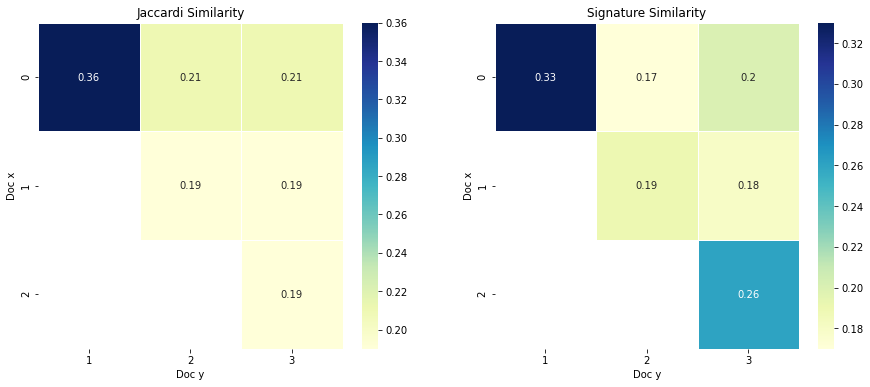

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

table = pd.pivot_table(df, values='Jaccardi Similarity', index=['Doc x'], columns=['Doc y'])
f, ax = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[0], cmap="YlGnBu")

table = pd.pivot_table(df, values='Signature Similarity', index=['Doc x'], columns=['Doc y'])
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[1], cmap="YlGnBu")

ax[0].set_title('Jaccardi Similarity')
ax[1].set_title('Signature Similarity')

`Locality Sensitive Hashing` with threshold 0.30 makes document 0 and 1 candidate pairs

In [42]:
lsh = LSH()
print(lsh.findCandidatePairs(sigMatHash, 0.30, bands=None, k=10**3))

4 documents have 1 candidate pairs
25 bands and 4 rows per band
Estimated similarity threshold: 0.4472135954999579
[(0, 1)]
